*Reminder: You may change runtime type to GPU for faster training.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Dataset

We use a classical example of CNN, [Digit Recognizer](http://yann.lecun.com/exdb/mnist/).

In [4]:
pip install python-mnist

In [5]:
from mnist import MNIST
mndata = MNIST()

X_train, Y_train = mndata.load_training()

test, test_labels = mndata.load_testing()

In [6]:
X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)
test = pd.DataFrame(test)
test_labels = pd.DataFrame(test_labels)

## **Normalization**

In the dataset, the scale and distribution of the data drawn from the domain may be different for each variable. This diffecence may cause incomprehensible results. 

###  

In our case, pixels are able to have 255 different values; therefore, the difference between black and white pixels would be huge. To handle this issue, we need to divide each pixel value by 255. This leads to the pixel values are valued between 0 and 1.

In [7]:
X_train = X_train / 255.0
test = test / 255.0

# Reshape 

We need to reshape the train set to be able to apply kernel and max-pooling. As the train data has 784 columns, we will split 784 into 28x28.

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Label Encoding

Keras expects labels as one-hot presentation.

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)
test_labels = to_categorical(test_labels, num_classes = 10)

# Train Validation Split
While training the model, we can evaluate how good it is with validation set. We should not use test set while training it because test set has to be that the model have never experienced.

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=10)

# Creating the model

CNN consists of 3 main parts: Convolution Layer, Pooling and Fully Connected (NN) Layer. 
- In the convolution layer, model tries to reconginze features of the image. 
- In pooling, the size of the input images is tried to reduce without losing recognizable information of the images. 
- In Fully Connected Layer, the neural network works here.

## Forward Propagation 

Compute the result of an operation and save any intermediates needed for gradient computation in memory.

- We perform convolution layer, pooling and fully connected layer and keep every results for back propagation.

## Back Propagation

Apply the chain rule to compute the gradient of the loss function with respect to the inputs.

- We need to assume that we get dh as input (from the backward pass of the next layer). It is important to understand that dh for the previous layer would be the input for the backward pass of the previous layer. Any change in weight in the filter will affect all the output pixels, because each weight in the filter contributes to each pixel in the output map.





References: https://www.linkedin.com/pulse/forward-back-propagation-over-cnn-code-from-scratch-coy-ulloa/

https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c

In [11]:
model = Sequential()

## Convolution Layer

- In this layer, model tries to extract feature maps of the images by using kernel (filter). We define a kernel size (3, 5 or 7) and this kernel strides on the images for extraction. 
- While doing that, we lose information of the images' edges (Valid Padding). To prevent it, the images' edges is filled with 0's (Same Padding). It also provides having same size feature maps with input images. 
- We can define step size with changing 'strides' parameter. Increasing helps faster model but may lead less accurate feature maps.
- We choose activation functions for the layer because we need to limitate the output of the layer and provide non-linearity for back-propogation. Relu is in use for this purpose.

In [12]:
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))

## Pooling

- It provides reduced number of parameters to make a faster model. 
- We choose size of the pool and it strides on the feature maps. Likeas convolution layer, we lose information about the image, but also we can prevent noise by choosing the biggest value in the pool (max-pooling), or we can just find the average value of the pool (average-pooling)
- We can define step size with changing 'strides' parameter. That helps faster model but may less accurate feature maps.

In [13]:
model.add(MaxPool2D(pool_size=(2,2)))

## Dropout
Dropout is a technique where randomly selected neurons are ignored during training.

In [14]:
model.add(Dropout(0.25))

In [15]:
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

## Fully Connected Layer

- Fully Connected Layer is a Neural Network where weights and bias are defined. 
- It has hidden layers. They are hidden because their outputs are not observed in the training set.
- We flatten the results of the convolution layer and pooling, and use it in Fully Connected Layer as inputs.

In [16]:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Optimizers

Optimizers provides to find better values for parameters that we valued.

In [17]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile Model

- We define a loss function and evaluation metrics.
- Categorical Crossentropy is a loss function that are used for multiclass problems.
  - Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events.
  - Entropy is the number of bits required to transmit a randomly selected event from a probability distribution.
  - Cross-entropy builds upon the idea of entropy from information theory and calculates the number of bits required to represent or transmit an average event from one distribution compared to another distribution.

Reference: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

In [18]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


# Batch Size and Epochs

Batch size divides the inputs into chunks and in every epoch these chunks are iterated. 

In [19]:
epochs = 10 
batch_size = 250

# Data Augmentation

- Data Augmentation prevents overfitting with changing the rotation and size of the images. 

- It is also useful when we have small size of dataset.

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Fit The Model

In [21]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
216/216 [==============================] - 43s 195ms/step - loss: 0.9051 - accuracy: 0.6997 - val_loss: 0.1492 - val_accuracy: 0.9580
Epoch 2/10
216/216 [==============================] - 44s 206ms/step - loss: 0.3514 - accuracy: 0.8898 - val_loss: 0.0968 - val_accuracy: 0.9723
Epoch 3/10
216/216 [==============================] - 41s 191ms/step - loss: 0.2640 - accuracy: 0.9172 - val_loss: 0.0813 - val_accuracy: 0.9750
Epoch 4/10
216/216 [==============================] - 41s 192ms/step - loss: 0.2298 - accuracy: 0.9279 - val_loss: 0.0705 - val_accuracy: 0.9777
Epoch 5/10
216/216 [==============================] - 48s 220ms/step - loss: 0.2031 - accuracy: 0.9370 - val_loss: 0.0614 - val_accuracy: 0.9797
Epoch 6/10
216/216 [==============================] - 42s 196ms/step - loss: 0.1822 - accuracy: 0.9435 - val_loss: 0.0554 - val_accuracy: 0.9818
Epoch 7/10
216/216 [==============================] - 41s 191ms/step - loss: 0.1678 - accuracy: 0.9480 - val_loss: 0.0499 - val_ac

## Evaluate The Model

### Validation Results Visualization

We can draw a graph that shows the results in every epoch.

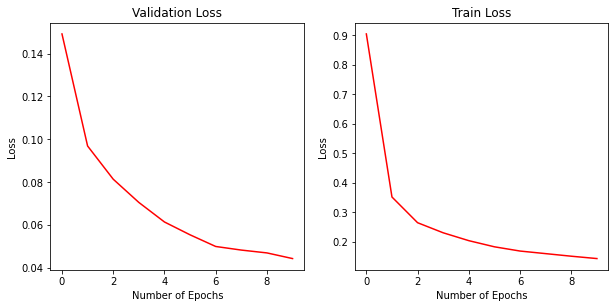

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.grid(False)
plt.ylabel("Loss")
plt.xlabel(("Number of Epochs"))
plt.title("Validation Loss")
plt.plot(history.history['val_loss'], color='r')

plt.subplot(2,2,2)
plt.grid(False)
plt.ylabel("Loss")
plt.xlabel(("Number of Epochs"))
plt.title("Train Loss")
plt.plot(history.history['loss'], color='r')

plt.show()


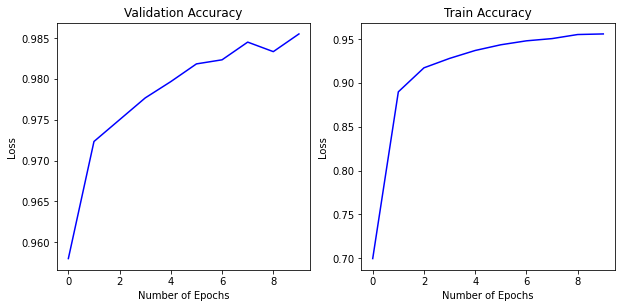

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.grid(False)
plt.ylabel("Loss")
plt.xlabel(("Number of Epochs"))
plt.title("Validation Accuracy")
plt.plot(history.history['val_accuracy'], color='b')

plt.subplot(2,2,2)
plt.grid(False)
plt.ylabel("Loss")
plt.xlabel(("Number of Epochs"))
plt.title("Train Accuracy")
plt.plot(history.history['accuracy'], color='b')

plt.show()


In [24]:
print("Evaluate on test data")
results = model.evaluate(test, test_labels)
print(f"test loss: {results[0]}, test acc: {results[1]}")

Evaluate on test data
313/313 [==============================] - 3s 11ms/step - loss: 0.0320 - accuracy: 0.9903
test loss: 0.03198542073369026, test acc: 0.9902999997138977


### Let's see first 10 test images:

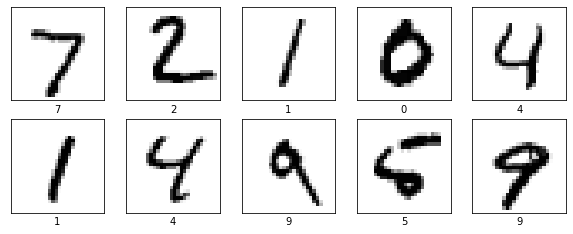

In [25]:
plt.figure(figsize=(10,10))
for i in range(10):
  image = test[i].reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel([j for j in range(10) if test_labels[i][j] == 1][0])

plt.show()

Generate predictions for 10 samples


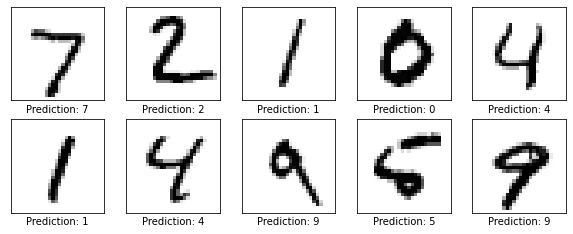

In [26]:
print("Generate predictions for 10 samples")
predictions = model.predict(test[:10])

max_indexes = np.argmax(predictions, axis=1)

plt.figure(figsize=predictions.shape)
for i in range(10):
  image = test[i].reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(f"Prediction: {max_indexes[i]}")

plt.show()

### Confusion Matrix
 - A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.


 Reference: https://machinelearningmastery.com/confusion-matrix-machine-learning/

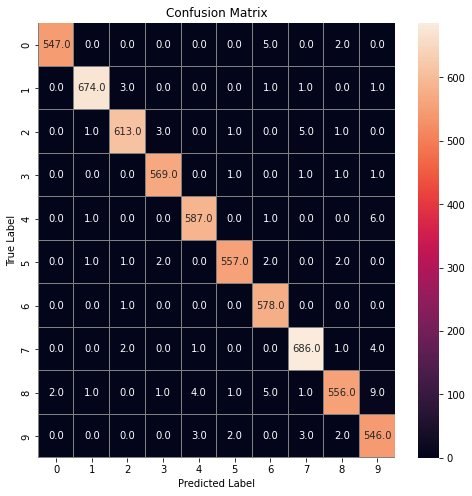

In [27]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()